In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge


df = pd.read_csv('house-prices/house_train.csv')
house = df.copy()
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [70]:
house.shape

(1460, 81)

In [71]:
null_val = pd.Series(house.isna().sum())
null_sort = null_val.sort_values(ascending=False)
null_sort.head(6)

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
FireplaceQu     690
LotFrontage     259
dtype: int64

In [72]:
house.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis=1, inplace=True)

In [73]:
house.shape

(1460, 76)

C:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


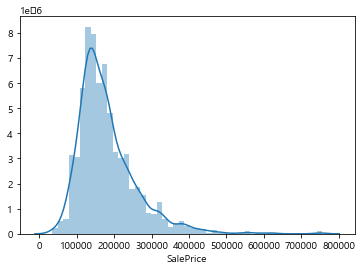

In [74]:
sns.distplot(house['SalePrice'])

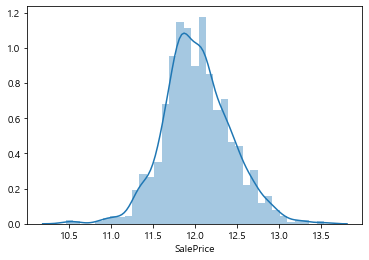

In [75]:
sns.distplot(np.log1p(house['SalePrice']))

In [76]:
house.fillna(house.mean(), inplace=True)

house['SalePrice'] = np.log1p(house['SalePrice'])
null_val = house.isna().sum()[house.isna().sum()>0]
print('null값이 있는 컬럼의 dtype : ', house.dtypes[null_val.index])

null값이 있는 컬럼의 dtype :  MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [77]:
house_ohe = pd.get_dummies(house)
print(house.shape)
print(house_ohe.shape)
print('null 값이 있는 컬럼 : ', house_ohe.isna().sum()[house_ohe.isna().sum()>0])

(1460, 76)
(1460, 272)
null 값이 있는 컬럼 :  Series([], dtype: int64)


In [78]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(f'{model.__class__.__name__} log 변환된 RMSE : {rmse : .4f}')
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [79]:
X_data = house_ohe.drop('SalePrice', axis=1)
y_target = house_ohe['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target,
                                                   test_size=0.3,
                                                   random_state=23)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression log 변환된 RMSE :  0.1384
Ridge log 변환된 RMSE :  0.1317
Lasso log 변환된 RMSE :  0.1725


[0.13843529521080405, 0.13173055451115498, 0.17246933076840235]

In [80]:
def get_coef(model):
    coef = pd.Series(model.coef_, index=X_data.columns)
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

C:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


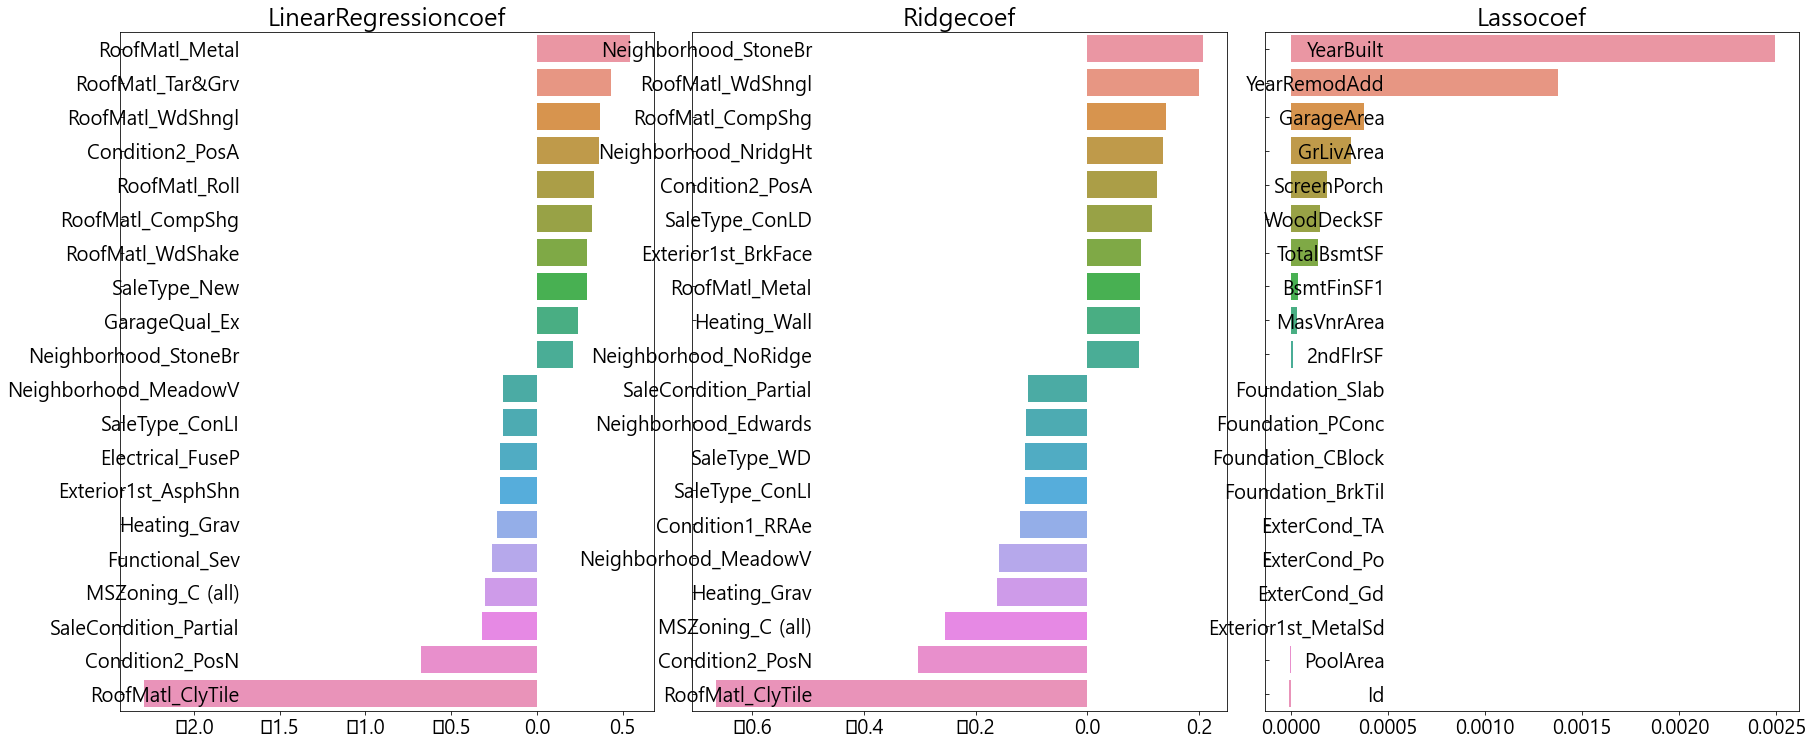

In [81]:
def coef_graph(models):
    fig, axs= plt.subplots(figsize=(24,10), ncols=3, nrows=1)
    fig.tight_layout()
    for num, model in enumerate(models):
        coef_high, coef_low = get_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        axs[num].set_title(model.__class__.__name__ + 'coef', size=25)
        axs[num].tick_params(axis='y', direction='in', pad=-120)
        for label in (axs[num].get_xticklabels() + axs[num].get_yticklabels()):
            label.set_fontsize(20)
            
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[num])
    
coef_graph(models)

In [82]:
def get_avg_cv(models):
    for model in models:
        rmse_list = np.sqrt(-1 * cross_val_score(model, X_data, y_target, scoring='neg_mean_squared_error',
                                                cv=5))
        rmse_avg = np.mean(rmse_list)
        print(f'{model.__class__.__name__} CV 평균 RMSE : {rmse_avg : .4f}')
    
get_avg_cv(models)

LinearRegression CV 평균 RMSE :  0.1555
Ridge CV 평균 RMSE :  0.1437
Lasso CV 평균 RMSE :  0.1976


In [83]:
def best_params(model, params):
    grid_model = GridSearchCV(model, param_grid = params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_data, y_target)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print(f'{model.__class__.__name__} CV 최적 평균 RMSE : {rmse : .4f}, 최적 alpha값 : {grid_model.best_params_}')
    return grid_model.best_estimator_

ridge_params = {'alpha' : [0.05,0.1, 1, 5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005,0.008,0.05,0.03,0.1, 0.5, 1.5 ,10]}

best_ridge = best_params(ridge_reg, ridge_params)
best_lasso = best_params(lasso_reg, lasso_params)

Ridge CV 최적 평균 RMSE :  0.1416, 최적 alpha값 : {'alpha': 10}
Lasso CV 최적 평균 RMSE :  0.1420, 최적 alpha값 : {'alpha': 0.001}


In [84]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha = 10)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha = 0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression log 변환된 RMSE :  0.1384
Ridge log 변환된 RMSE :  0.1277
Lasso log 변환된 RMSE :  0.1230


[0.13843529521080405, 0.1276824841257006, 0.12298577168876546]

In [85]:
from scipy.stats import skew

data_index = house.dtypes[house.dtypes!='object'].index
skew_data = house[data_index].apply(lambda x : skew(x))

skew_top = skew_data[skew_data>1]
skew_top.sort_values(ascending=False)

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64

In [86]:
house[skew_top.index] = np.log1p(house[skew_top.index])

In [87]:
house_ohe = pd.get_dummies(house)
X_data = house_ohe.drop('SalePrice', axis=1)
y_target = house_ohe['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3,
                                                   random_state=23)
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = best_params(ridge_reg, ridge_params)
best_lasso = best_params(lasso_reg, lasso_params)

Ridge CV 최적 평균 RMSE :  0.1274, 최적 alpha값 : {'alpha': 10}
Lasso CV 최적 평균 RMSE :  0.1251, 최적 alpha값 : {'alpha': 0.001}


LinearRegression log 변환된 RMSE :  0.1311
Ridge log 변환된 RMSE :  0.1193
Lasso log 변환된 RMSE :  0.1136


C:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


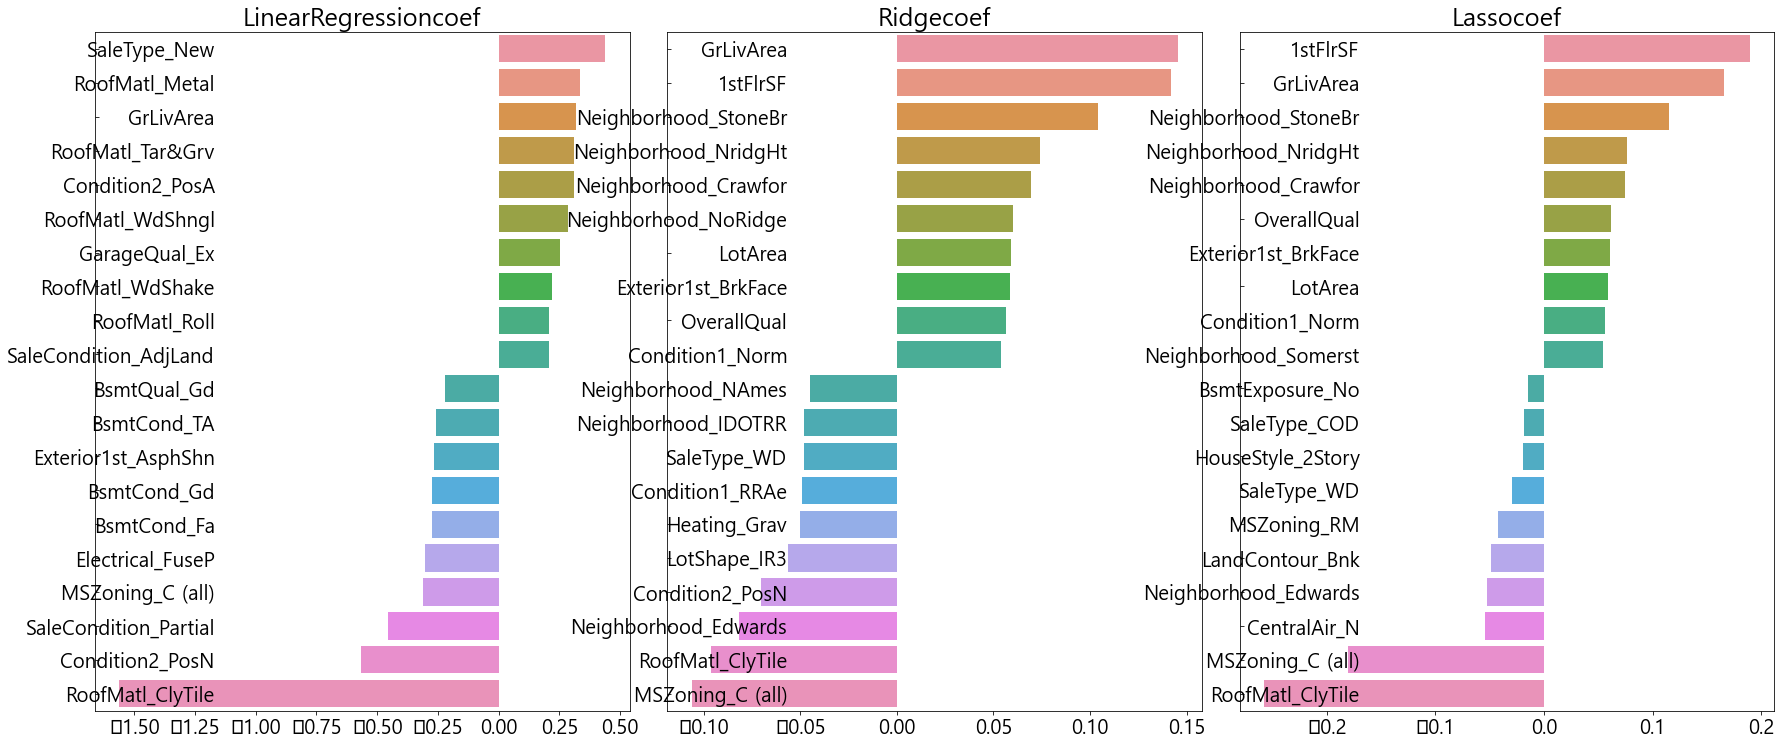

In [88]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha = 10)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha = 0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

models = [lr_reg, ridge_reg, lasso_reg]
coef_graph(models)